# Codebase 3: Statistical Analysis

In this section, we examine 5 features of the data:

- the generalized relationship between threshhod drawdowns and gdp growth
- the comparative distributions of drawdowns across sectors
- various measures of persistence across company performance in the worst drawdown quartile

__(1) Relationship between Number of Threshhold Drawdowns and GDP Growth__

In the previous data exploration section, we saw an expected increase in the numnber of threshhold drawdowns over the two US recessions captured in the review period. We will now investigate whether this genaralizes to a meaningful correlation with US GDP growth.

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

#specify inputs
input_master = 'hold_out_2015_TfidfVectorizer_unigram.pickle'
x_drop_columns = ['ticker_', 'max_dd_1yr',
       'max_dd_2yr', 'custom_sector']

#load data
dict_master = pd.read_pickle(input_master)
#select training data df
df = dict_master['min_df_15']['df_train_master']
#drawdown df
df_dd = dict_master['min_df_15']['df_train_master'][['Filed_Date', 
                                        'ticker_', 'sector_','sic_sector', 
                                            'max_dd_1yr', 'year_dd_flag', 
                                                     'cum_year_dd_flag']]
#td-idf word vector df
df_wv = df.drop(x_drop_columns, axis=1)

#memory management
del dict_master, df


In [3]:
#Define pos events and wrap in df
mask_pos_events = df_dd['max_dd_1yr'] <= -0.8
pos_events = (mask_pos_events*1).values
df_events_ts = pd.DataFrame(pos_events, columns=['pos_event'])
#format and count by year groupby
df_events_ts['year_'] = (df_dd['Filed_Date'].dt.year).values
df_num_events = df_events_ts.groupby('year_').sum()[1:]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#load and format us gdp growth from csv
us_gdp = pd.read_csv('US GDP Growth.csv')
us_gdp = pd.melt(us_gdp, id_vars='Year',var_name='year_', value_name= 'gdp_growth')
us_gdp = us_gdp.drop('Year', axis=1)
us_gdp = us_gdp.set_index('year_', drop=True).loc['1997':'2014',:]
#exclude first stub year
us_gdp = us_gdp[1:]
#add annual change in number of pos events to gdp df
us_gdp['num_events_%'] = (df_num_events[1:].values / df_num_events[:-1].values -1)*100

As seen so many times over my career in finance, one could produce an aesthetically pleasing but statsistically questionable graph showing the relationship between US GDP growth and __number__ of threshhold drawdowns:

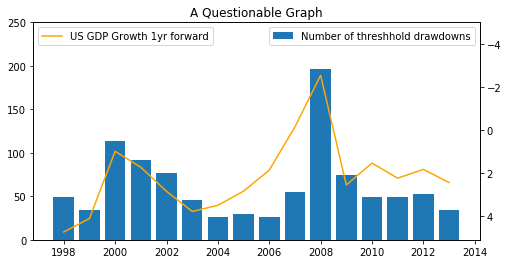

In [5]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax2 = ax1.twinx()
ax1.bar(df_num_events.index[1:-1], df_num_events.iloc[1:-1,0], 
        label='Number of threshhold drawdowns')
ax1.set_ylim(top=250)
ax2.plot(df_num_events.index[1:-1], us_gdp.iloc[1:,0].values, c='orange')
ax2.invert_yaxis()
ax2.set_ylim(top=-5)
plt.title('A Questionable Graph');
ax1.legend(['Number of threshhold drawdowns'], loc=0);
ax2.legend(['US GDP Growth 1yr forward'], loc=2);


Instead, we will consider a regression plot between the annual change in the number of threshhold drawdowns and US gdp growth:

correlation / R-squared with no lag :  0.16  /  0.03
correlation / R-sqaured with 1yr lag :  -0.44  /  0.19


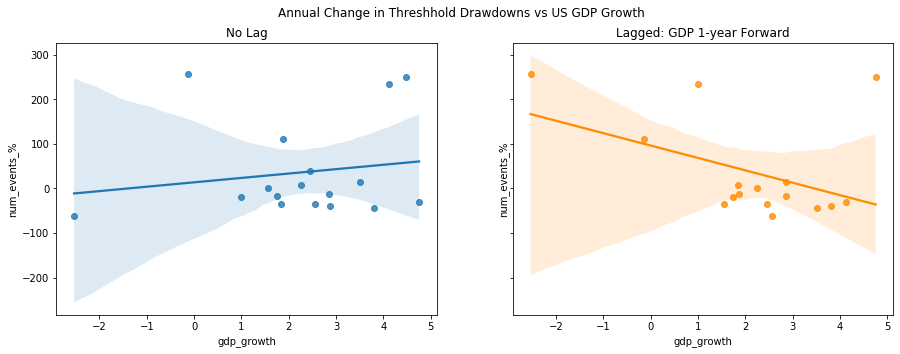

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
sns.regplot(us_gdp.iloc[:,0],us_gdp.iloc[:,1], ax=ax1);
sns.regplot(us_gdp.iloc[1:,0],us_gdp.iloc[:-1,1], ax=ax2, color='darkorange');
fig.suptitle('Annual Change in Threshhold Drawdowns vs US GDP Growth')
ax1.title.set_text('No Lag')
ax2.title.set_text('Lagged: GDP 1-year Forward')

corr_no_lag = np.corrcoef(us_gdp.iloc[:,0],us_gdp.iloc[:,1] )
corr_lag = np.corrcoef(us_gdp.iloc[1:,0],us_gdp.iloc[:-1,1] )
print('correlation / R-squared with no lag : ', "{:.2f}".format(corr_no_lag[0,1]),
                                         ' / ', "{:.2f}".format(corr_no_lag[0,1]**2) )
print('correlation / R-sqaured with 1yr lag : ', "{:.2f}".format(corr_lag[0,1]),
                                             ' / ', "{:.2f}".format(corr_lag[0,1]**2) )

__The negative relationship is only evident with the 1yr lag and with an r-sqaured of 19% is relatively modest. This lag effect is owing to a combination of the construc tion of the data where the drawdown is labeled by the filing date of the preceding annual statements and from the tendency for markets to lead the real economy. From visual inspection, we see that outside of the low growth / recession tail the relationship is minimal and the regression line relies on the leverage of the low / negative growth points to draw the relationship. The conclusion is that, wit only two instances, US recessions appear to have a meaningful and lagged negative correlation with threshhold drawdowns but that this fails to menagingfully extend to more normal levels of gdp growth.__   

__(2) Drawdown Distributions Across Sectors__

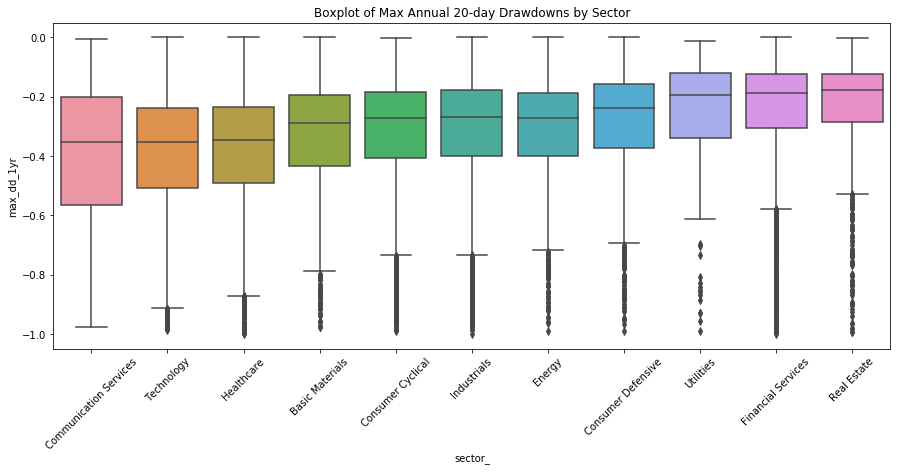

In [7]:
#order by worst mean dd
df_sect_dd_mean = df_dd[['sector_','max_dd_1yr']].groupby('sector_').mean()
df_sect_dd_mean = df_sect_dd_mean.sort_values(by='max_dd_1yr')
df_sect_dd_mean 
ordered_sect = df_sect_dd_mean.index.tolist()
#plot boxplot and order by highest dd to lowest
fig= plt.figure(figsize=(15,6))
_ = sns.boxplot(x=df_dd.sector_, y=df_dd.max_dd_1yr, order = ordered_sect)
_ = plt.xticks(rotation=45)
_ = plt.title('Boxplot of Max Annual 20-day Drawdowns by Sector')

__We see a noticeable difference in drawdown statistics by sector with communictaion services having the highest drawdown and volatility by some margin. Technology and Healthcare round out the bottom 3 while Utilities, Financial Services and Real Estate comprise the top 3. The bottom interdeciles are also well behaved in that they follow the same order as the medians. what is more interesting is that the outliers extend all the way down to 100% equity drawdown. In particular, and in reference to the observations in the "Data Storytelling" notebook, we observe the gappy outliers in utilities.__

__(3) Annual Persistence of Companies in Worst Quantile__ 

(v) On the individual company basis, it would be interesting to see the persisitence of "bad companies". To explore this, we can look at the persistence of this population in the bottom quartile of drawdowns on an annual basis:

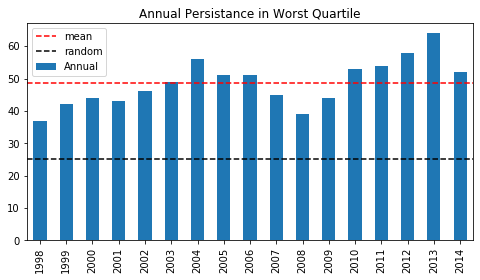

In [8]:
#Select cols for persistence
df_persist = df_dd[['ticker_', 'Filed_Date', 'max_dd_1yr']]
df_persist.loc[:,'year_'] = (df_persist['Filed_Date'].dt.year).values
df_persist = df_persist.drop('Filed_Date', axis=1)
#Years to list for looping
years = set(df_persist['year_'].tolist())
years = list(years)

#Loop through years and take qcut
df_final = pd.DataFrame()
for year in years:
    mask_yr = df_persist['year_'] == year
    df = df_persist[mask_yr]
    df['ann_qcut'] = pd.qcut(df['max_dd_1yr'], q=[0,0.25,0.5,0.75,1], 
                                labels=[4,3,2,1])
    df_final = pd.concat([df_final, df])
#frop stub year
df_persist = df_final[(df_final.year_ > 1996)].drop('max_dd_1yr', axis=1)
#Worst quartile only
df_p_q4 = df_persist[df_persist.ann_qcut == 4]

#Calc previous years rank
years = years[1:]
n=len(years)
dict_persist_perc = {}
#not pythonic but does the job for time series
for j in range(n-1):               
    current_yr = years[j+1]
    prev_yr = years[j]
    mask_current = df_p_q4.year_ == current_yr
    mask_prev = df_p_q4.year_ == prev_yr
    #list prev year q4 tickers
    prev_ticks = df_p_q4['ticker_'][mask_prev].tolist() 
    #number tickers in current q4
    len_current = mask_current.sum()    
    #number tickers in current q4 who also in last year's q4
    len_current_in_prev = (df_p_q4['ticker_'][mask_current].isin(prev_ticks)).sum()
    #percentage same
    persist_perc = round(100* len_current_in_prev / len_current,0)
    dict_persist_perc.update({current_yr: persist_perc})

#results dict to series
s_persist_perc = pd.Series(dict_persist_perc)
ave_persist_perc = s_persist_perc.mean()

#plot graph
fig= plt.figure(figsize=(8,4))
_ = s_persist_perc.plot(kind='bar', label='Annual')
_ = plt.title('Annual Persistance in Worst Quartile')
_ = plt.axhline(ave_persist_perc, c='red', ls='--', label='mean')   
_ = plt.axhline(25, c='black', ls='--', label='random')   

_ = plt.legend()
    

    

__The above graph plots what percentage of companies in the current year's worst quartile were also in the worst quartile in the previous year. Average persistance (weighted evenly by year) is just under 50% and we see that all years are well above what we'd expect from random chance (25%). Persistence in maximum drawdowns indicates that risky companies stay risky over long time periods. From the moddelling viewpoint, it indicates autocorrelation and implies that companies in last year's bottom quartile are more likely to be in this years bottom quartile and thus a candidate for the threshhold drawdown. Interestingly, we also note that this persistence at its lowest in recession years (2001/02 and 2008/09)  when the number of threshhold drawdowns spike.__

__(4) "Persistence" for Positive Events__

Applying the idea of persistence to positive events only, we now plot a histogram of the quartile rank of a positive event company in the year preceding the threshhold drawdown. 

Histogram: Previous Quartile of Company before a Positive Event

quartile  1  =  3.43 %
quartile  2  =  9.19 %
quartile  3  =  23.15 %
quartile  4  =  64.23 %


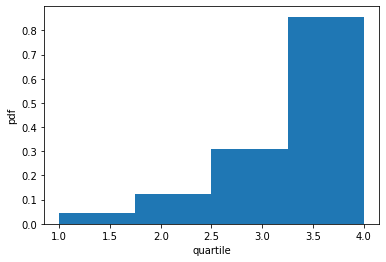

In [9]:
#positive event companies and years

mask_pos = df_dd.year_dd_flag == 1
pos_ticker_list = df_dd['ticker_'][mask_pos].tolist()
prev_year_list = (df_dd['Filed_Date'].dt.year -1)[mask_pos].tolist()

df_dummy=pd.DataFrame(pos_ticker_list, columns=['ticker_'])
df_dummy.loc[:,'year_'] = prev_year_list
df_dummy.loc[:,'dummy_'] = 1

df_pos_prev = df_dummy.merge(df_persist, on=['year_', 'ticker_'], how='inner')
df_pos_prev = df_pos_prev.drop('dummy_', axis=1)
vals_pos = df_pos_prev['ann_qcut'].values


print('Histogram: Previous Quartile of Company before a Positive Event')
print('')
_ = plt.hist(vals_pos, density=True, bins=4)
_ = plt.xlabel('quartile')
_ = plt.ylabel('pdf')


for num in range(1,5):
    perc = 100*sum(vals_pos==num) / vals_pos.shape[0]
    print('quartile ', str(num), ' = ',"{:.2f}".format(perc),'%')


__In light of the preceding analysis, the shape fo the histogram is not surprsing. Fully 64% of positive events are in the worst quartile in the year preceding this and, just as interestingly, only 13% are in the top 50% (quartiles 1 and 2). The latter observation gives us some ideas of how we might use the previous year's quartile rank to increase precision and reduce false positives in the end model. How helpful this might be will have to wait until model learning and cross validation.__

__(5) Persistence of Bad / Risky Companies__

While the event label for the project focuses on the document of a company in a particular year, we also have a notion (already suggested by (3) and (4) above) of bad or risky companies. To this end, we will consider the same histogram design as in (4) but this time split between companies with positive events and those without.

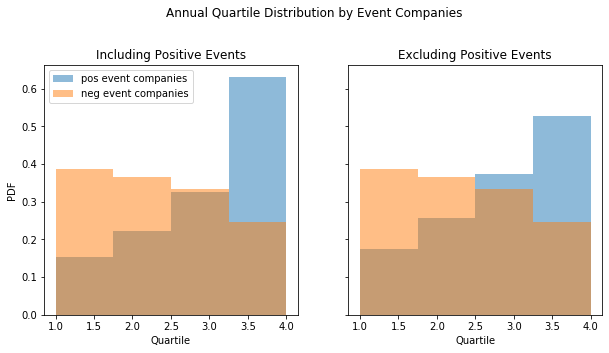

In [10]:
pos_tickers= set(pos_ticker_list)
all_tickers = set(df_dd.ticker_.tolist())
neg_tickers = all_tickers - pos_tickers

df_qcut = df_persist.copy()
df_qcut['event_comp'] = df_qcut['ticker_'].apply(lambda x: 'pos' if x in pos_tickers else 'neg')
mask_qcut_pos = df_qcut['event_comp'] == 'pos'

pos_vals = df_qcut['ann_qcut'][mask_qcut_pos].values
neg_vals = df_qcut['ann_qcut'][~mask_qcut_pos].values

#remove pos event years for pos set
idx = np.argsort(pos_vals)
pos_vals_adj = pos_vals[idx]
n_pos_events = vals_pos.shape[0]
pos_vals_adj = pos_vals_adj[n_pos_events:]

#plot histograms

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
fig.suptitle('Annual Quartile Distribution by Event Companies')

ax1.hist(pos_vals, density=True, bins=4, alpha=0.5, label='pos event companies');
ax1.hist(neg_vals, density=True, bins=4, alpha=0.5, label='neg event companies');
ax1.set_title('Including Positive Events');
ax1.set_xlabel('Quartile');
ax1.set_ylabel('PDF');
ax1.legend(loc="upper left");

ax2.hist(pos_vals_adj, density=True, bins=4, alpha=0.5);
ax2.hist(neg_vals, density=True, bins=4, alpha=0.5);
ax2.set_title('Excluding Positive Events');
ax2.set_xlabel('Quartile');

plt.subplots_adjust(top=0.82)


__The positive event companies have a far higher frequency of time spent in the bottom quartile. This is true even one when removes the positive events themselves.__ 